# State Level Salary Comparison
In this notebook, we will be breaking down the salary expectation of *Science*, *Technology*, *Engineering*, and *Mathematics* (STEM) related positions. We will be performing this analysis by using a dataset [available online](https://www.kaggle.com/jackogozaly/data-science-and-stem-salaries).

Specifically, we will be comparing the salaries of STEM related positions at a state-level. We have certain expectations going into this analysis, such as California having a higher average salary than other states.

It should be noted that our dataset is not restricted to the USA. It will be interesting to see a comparison between the salaries received in America vs Europe for similar positions.

---

## Data Preparation
The next few cells are for importing necessary packages, as well as defining our schema and loading in our data. 

In [1]:
#Let's read in our packages
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession, Row
from pyspark import SparkConf

import pandas as pd
import numpy as np

In [3]:
#Instantiate a spark session
spark = SparkSession \
    .builder \
    .appName("Spark State-Level Salary Analysis") \
    .getOrCreate()

In [4]:
# Let's define our schema
schema = StructType([\
    StructField("date", DateType(), True),\
    StructField("time", StringType(), True),\
    StructField("company", StringType(), True),\
    StructField("level", StringType(), True),\
    StructField("title", StringType(), True),\
    StructField("totalyearlycompensation", IntegerType(), False),\
    StructField("location", StringType(), True),\
    StructField("yearsofexperience", FloatType(), False),\
    StructField("yearsatcompany", FloatType(), False),\
    StructField("tag", StringType(), True),\
    StructField("basesalary", IntegerType(), False),\
    StructField("stockgrantvalue", IntegerType(), False),\
    StructField("bonus", IntegerType(), False),\
    StructField("gender", StringType(), True),\
    StructField("cityid", StringType(), True),\
    StructField("dmaid", StringType(), True),\
    StructField("race", StringType(), True),\
    StructField("education", StringType(), True)])

# Load and parse the data file, converting it to a DataFrame.
data = spark.read.format("csv")\
    .option("header", "false")\
    .option("delimiter", "\t")\
    .schema(schema)\
    .load("../data/seperated_time_data/cleaned.txt")
data.show(n=5)

+----------+--------+---------+-----+--------------------+-----------------------+-----------------+-----------------+--------------+---+----------+---------------+-----+------+------+-----+----+---------+
|      date|    time|  company|level|               title|totalyearlycompensation|         location|yearsofexperience|yearsatcompany|tag|basesalary|stockgrantvalue|bonus|gender|cityid|dmaid|race|education|
+----------+--------+---------+-----+--------------------+-----------------------+-----------------+-----------------+--------------+---+----------+---------------+-----+------+------+-----+----+---------+
|2017-06-07|   11:33|   ORACLE|   L3|     Product Manager|                 127000| Redwood City, CA|              1.5|           1.5| NA|    107000|          20000|10000|    NA|  7392|  807|  NA|       NA|
|2017-06-10|   17:11|     EBAY| SE 2|   Software Engineer|                 100000|San Francisco, CA|              5.0|           3.0| NA|    141907|              0|    0|    NA

The first thing we'd like to look at is how many unique locations do we have? We must remember that we are trying to work at state-level, so any locations with the same state should be considered as part of the same group. From viewing the *location* column in the snippet above, we see that states are denoted by their **2 leter acronym** at the end of the location text.

Let's also try to inspect the strings for locations outside of the United States.

In [5]:
split_location = split(data['location'], ', ')
data_with_state = data.withColumn('state', split_location.getItem(1))
data_with_state.show(n=2)

+----------+-----+-------+-----+-----------------+-----------------------+-----------------+-----------------+--------------+---+----------+---------------+-----+------+------+-----+----+---------+-----+
|      date| time|company|level|            title|totalyearlycompensation|         location|yearsofexperience|yearsatcompany|tag|basesalary|stockgrantvalue|bonus|gender|cityid|dmaid|race|education|state|
+----------+-----+-------+-----+-----------------+-----------------------+-----------------+-----------------+--------------+---+----------+---------------+-----+------+------+-----+----+---------+-----+
|2017-06-07|11:33| ORACLE|   L3|  Product Manager|                 127000| Redwood City, CA|              1.5|           1.5| NA|    107000|          20000|10000|    NA|  7392|  807|  NA|       NA|   CA|
|2017-06-10|17:11|   EBAY| SE 2|Software Engineer|                 100000|San Francisco, CA|              5.0|           3.0| NA|    141907|              0|    0|    NA|  7419|  807|  

## American States
In the above snippet, you can see that we've added a **state** column to each row. We can now groupby this column, and find averages for each of our monetary columns.

Once, we group are initial dataframe by state ID, we'll create a new dataframe to represent the averages of the monetary values for that given state. We will then seperate out the entries representing American States only. We must also round our averages up to 1 decimal place to make things more readable.

In [6]:
#Get list of rows, each entry represents a state
averages = data_with_state['state', 'location', 'totalyearlycompensation',
                           'basesalary', 'stockgrantvalue', 'bonus']\
    .groupBy('state')\
    .avg().collect()
len(averages)

201

In [7]:
#Create dataframe from rows
averages_df = spark.createDataFrame(averages)

In [8]:
#Seperate out american state entries

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

american_averages_df = spark.createDataFrame(averages_df.filter(averages_df.state.isin(states)).collect())
american_averages_df.show(n=2)

+-----+----------------------------+------------------+--------------------+------------------+
|state|avg(totalyearlycompensation)|   avg(basesalary)|avg(stockgrantvalue)|        avg(bonus)|
+-----+----------------------------+------------------+--------------------+------------------+
|   SC|           94168.83116883117| 81374.20779220779|  6844.1558441558445| 7779.220779220779|
|   AZ|          149707.12401055408|115676.38258575198|  19023.746701846965|13936.675461741424|
+-----+----------------------------+------------------+--------------------+------------------+
only showing top 2 rows



In [9]:
#Now we want to round all our values to 1 decimal place
for c in american_averages_df.columns[1:]:
    american_averages_df = american_averages_df.withColumn(c, round(c, 0))

american_averages_df.show(n=5)

+-----+----------------------------+---------------+--------------------+----------+
|state|avg(totalyearlycompensation)|avg(basesalary)|avg(stockgrantvalue)|avg(bonus)|
+-----+----------------------------+---------------+--------------------+----------+
|   SC|                     94169.0|        81374.0|              6844.0|    7779.0|
|   AZ|                    149707.0|       115676.0|             19024.0|   13937.0|
|   LA|                     97040.0|        77520.0|             12400.0|    7040.0|
|   MN|                    146403.0|       122843.0|             10112.0|   13147.0|
|   NJ|                    169752.0|       135162.0|             15022.0|   19357.0|
+-----+----------------------------+---------------+--------------------+----------+
only showing top 5 rows



### American State Compensation
As expected, according to our data, Californian STEM employees receive on average the highest yearly compensation. Washington follows closely in second, and New York state is third. Beyond the third entry we see a sharp decline in total compensation, with Michigan appearing in 4th place. 

Let's use `matplotlib` to create a choropleth map of America displaying the annual yearly compensation per state.

In [10]:
from chart_studio import plotly as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [11]:
#Let's convert our pyspark dataframe to a pandas df for visualisation
pandasdf = american_averages_df.toPandas()
pandasdf.rename(columns={'avg(totalyearlycompensation)':'total comp', 'avg(basesalary)':'base sal',
                         'avg(stockgrantvalue)': 'sg val', 'avg(bonus)':'bonus'}, inplace=True)
pandasdf.head(2)

,state,total comp,base sal,sg val,bonus
0,SC,94169.0,81374.0,6844.0,7779.0
1,AZ,149707.0,115676.0,19024.0,13937.0


In [12]:
#Let df equal the spatial coordinates of states
df = pandasdf

fig = go.Figure(data=go.Choropleth(
    locations=df['state'], # Spatial coordinates
    z = df['total comp'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'blues',
    colorbar_title = "Thousands USD",
))

fig.update_layout(
    title_text = '2017 to 2021 US STEM Related Positions Average Annual Compensation by State',
    geo_scope='usa', # limite map scope to USA
)
fig.write_image("../Graph Outputs/us-states.png")
fig

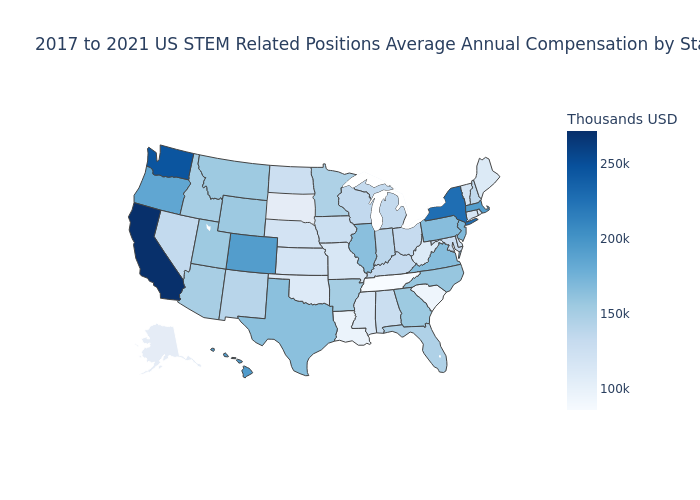

In [13]:
from IPython.display import Image
PATH = "../Graph Outputs/us-states.png"
Image(filename=PATH, width=900)

### Graph Analysis

**NOTE** We cannot display the interactive Plotly graph, so instead we will display a static png.

It's interesting to note that two states are missing from our data:
1. South Dakota (SD)
2. Alaska (AK)

We already know that California, Washington, and New York achieve the highest overall average annual compensation. From the graph, it appears than Tennessee received the lowest annual compensation over the past 4 years.

It's interesting to note that STEM related positions seem most prosperous in coastal areas. It is unlikely that there is a single clear-cut answer for this. STEM related positions appear more often in built-up regions. If we view the midlands of the United States, such as Nebraska, Kansas, and Oklahoma, we see a large disparity between expected salaries here versus the coastal regions. This is likely due to the fact that these states do not have as large built-up regions, and predominately home the majority of the American farming industry.

---

# Rest of the World
Let's now do a similar analysis with respect to the non-American states, countries, and cities within our dataset. To get our data, we just want the opposite of items found in the `states` list variable. However, as the locations are more complex, we'll need to further investigate.

In [14]:
#Split our location data into an array
split_location = split(data['location'], ', ')

#Create a new column for our array
data_with_location_array = data.withColumn('loc_array', split_location)

#Filter by the array column where array has more than 2 entries 
european_data = data_with_location_array.where(size(col('loc_array')) > 2)

european_data = european_data.withColumn('country',european_data['loc_array'][2])
european_data.show(n=2)

+----------+--------+-------+-----+-----------------+-----------------------+--------------------+-----------------+--------------+---+----------+---------------+-----+------+------+-----+----+---------+--------------------+--------------+
|      date|    time|company|level|            title|totalyearlycompensation|            location|yearsofexperience|yearsatcompany|tag|basesalary|stockgrantvalue|bonus|gender|cityid|dmaid|race|education|           loc_array|       country|
+----------+--------+-------+-----+-----------------+-----------------------+--------------------+-----------------+--------------+---+----------+---------------+-----+------+------+-----+----+---------+--------------------+--------------+
|2017-07-24|12:21:07|  APPLE|   L4|Software Engineer|                  50000|London, EN, Unite...|              2.0|           2.0| NA|    141907|              0|    0|    NA| 12008|    0|  NA|       NA|[London, EN, Unit...|United Kingdom|
|2017-08-13|10:57:56| AMAZON|   L5|Softw

In [15]:
#Let's groupby country
other_averages = european_data['country', 'location', 'totalyearlycompensation',
                           'basesalary', 'stockgrantvalue', 'bonus']\
    .groupBy('country')\
    .avg().collect()

#Create dataframe from rows
other_averages_df = spark.createDataFrame(other_averages)

In [16]:
#Now we want to round all our values to 1 decimal place
for c in other_averages_df.columns[1:]:
    other_averages_df = other_averages_df.withColumn(c, round(c, 0))

other_averages_df.show(n=5)

+-----------+----------------------------+---------------+--------------------+----------+
|    country|avg(totalyearlycompensation)|avg(basesalary)|avg(stockgrantvalue)|avg(bonus)|
+-----------+----------------------------+---------------+--------------------+----------+
|     Russia|                     59773.0|        39139.0|             15460.0|    6732.0|
|     Sweden|                     92929.0|        87113.0|             10250.0|    4000.0|
|Philippines|                    179000.0|       128181.0|               800.0|    7400.0|
|      Burma|                     15000.0|        10000.0|              4000.0|    1000.0|
|  Singapore|                    145038.0|       103472.0|             25110.0|   16682.0|
+-----------+----------------------------+---------------+--------------------+----------+
only showing top 5 rows



## Visualisation
So from here, in order to understand our data, we will use various visualisations. Creating a chloropleth map for American states is a much easier process than for various European and Asian countries. Let's firstly begin with some simpler visualisation.

As before, we must convert our dataframe to a pandas dataframe object to use matplotlib

In [17]:
#Convert to pandas
pandasdf2 = other_averages_df.toPandas()
pandasdf2.rename(columns={'avg(totalyearlycompensation)':'total comp', 'avg(basesalary)':'base sal',
       'avg(stockgrantvalue)':'sg value', 'avg(bonus)':'bonus'}, inplace=True)

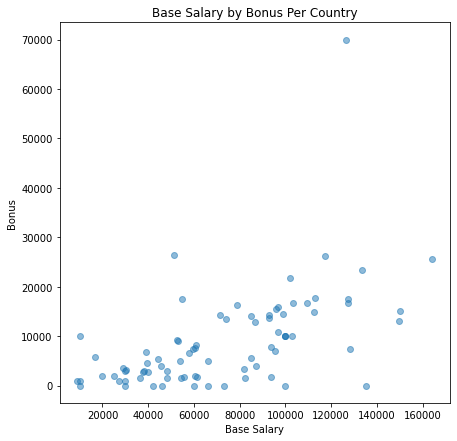

In [18]:
#Let's make a scatterplot
plt.figure(figsize=(7,7))

x = pandasdf2['base sal']
y = pandasdf2['bonus']

plt.title('Base Salary by Bonus Per Country')
plt.xlabel('Base Salary')
plt.ylabel('Bonus')
plt.scatter(x, y, alpha=0.5)
plt.show()

### Scatterplot Analysis
From our graph it's clear that most countries receive between $[0, 30000]$ as a bonus. We do see one outlier receiving on average, over 70,000 per annum bonus. Let's see which country this is.

In the below cell, we see that this country is Saudi Arabia. Saudi Arabia is a wealthy country, and is currently experience an economic boom. Therefore, it's not surprising that the salaries and bonuses in Saudi Arabia are high.

In [19]:
pandasdf2.sort_values(by='bonus', ascending=False).head(1)

,country,total comp,base sal,sg value,bonus
47,Saudi Arabia,199750.0,126250.0,3250.0,70000.0


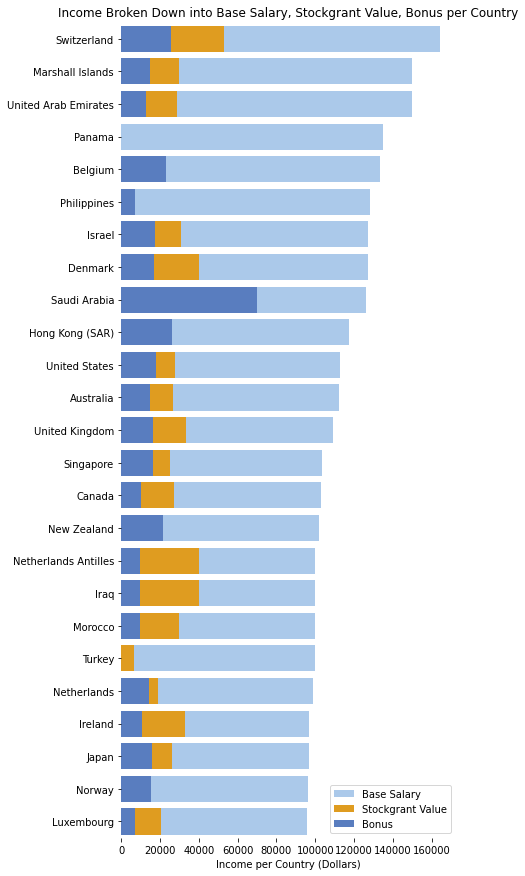

In [20]:
import seaborn as sns

pandasdf2.sort_values(by='base sal', ascending=False, inplace=True)
top_25 = pandasdf2.head(25)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="base sal", y="country", data=top_25,
            label="Base Salary", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("pastel")
sns.barplot(x="sg value", y="country", data=top_25,
            label="Stockgrant Value", color="orange")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="bonus", y="country", data=top_25,
            label="Bonus", color="b")

# Add a legend and informative axis label
plt.title('Income Broken Down into Base Salary, Stockgrant Value, Bonus per Country')
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Income per Country (Dollars)")
sns.despine(left=True, bottom=True)

### Horizontal Bar-Chart Analysis
The top 20 countries with the highest base salary are presented above. The second entry of *Marshall Islands* is a bit unexpected, and one might question its legitimacy. In the below cell, we use our base dataframe to count the number of instances where 'Marhsall Islands' is the location. We see that there is only a single instance where this is the case.

Following on from this find, we will redefine our dataset to include only countries with more than 5 entries. Let's see how this changes our visualisation.

In [21]:
#Check how many instances register Marshall Islands as locaiton
european_data.filter(european_data.country == 'Marshall Islands').collect()

[Row(date=datetime.date(2019, 6, 17), time='22:29:16', company='EBAY', level='3', title='Software Engineer', totalyearlycompensation=195000, location='Kwajalein, MH, Marshall Islands', yearsofexperience=2.0, yearsatcompany=2.0, tag='Distributed Systems (Back-End)', basesalary=150000, stockgrantvalue=30000, bonus=15000, gender='Male', cityid='11982', dmaid='0', race='NA', education='NA', loc_array=['Kwajalein', 'MH', 'Marshall Islands'], country='Marshall Islands')]

In [22]:
#Count the number of appearances for each countr
counts = european_data['country', 'location', 'totalyearlycompensation',
                           'basesalary', 'stockgrantvalue', 'bonus']\
    .groupBy('country')\
    .count().collect()

#Create a dataframe
counts = spark.createDataFrame(counts)

#Merge that with our previous grouped dataframe
new_european_data = other_averages_df.join(counts, on='country')

In [23]:
new_european_data.show(n=2)

+-------+----------------------------+---------------+--------------------+----------+-----+
|country|avg(totalyearlycompensation)|avg(basesalary)|avg(stockgrantvalue)|avg(bonus)|count|
+-------+----------------------------+---------------+--------------------+----------+-----+
| Russia|                     59773.0|        39139.0|             15460.0|    6732.0|  249|
| Sweden|                     92929.0|        87113.0|             10250.0|    4000.0|   56|
+-------+----------------------------+---------------+--------------------+----------+-----+
only showing top 2 rows



In [24]:
#For a final step let's filter out countries with less than 5 entries
new_european_data = new_european_data.filter(new_european_data['count'] > 4).collect()
new_european_data = spark.createDataFrame(new_european_data)

In [25]:
#Convert to pandas and plot
pandasdf3 = new_european_data.toPandas()
pandasdf3.rename(columns={'avg(totalyearlycompensation)':'total comp', 'avg(basesalary)':'base sal',
       'avg(stockgrantvalue)':'sg value', 'avg(bonus)':'bonus'}, inplace=True)

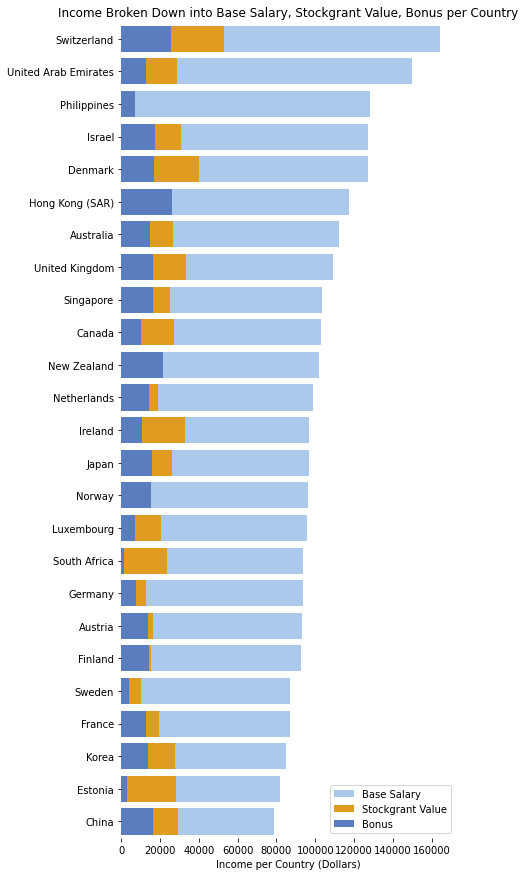

In [26]:
import seaborn as sns

pandasdf3.sort_values(by='base sal', ascending=False, inplace=True)
top_25 = pandasdf3.head(25)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="base sal", y="country", data=top_25,
            label="Base Salary", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("pastel")
sns.barplot(x="sg value", y="country", data=top_25,
            label="Stockgrant Value", color="orange")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="bonus", y="country", data=top_25,
            label="Bonus", color="b")

# Add a legend and informative axis label
plt.title('Income Broken Down into Base Salary, Stockgrant Value, Bonus per Country')
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Income per Country (Dollars)")
sns.despine(left=True, bottom=True)
plt.savefig("../Graph Outputs/income-by-country.png", bbox_inches='tight')

### New Horizontal Bar Chart Analysis
We see that limiting our list to countries with 5 or more entries has removed some of the unexpected countries such as Marshall Islands, Iraw, and Morocco. It also dropped Saudi Arabia from our list.

We see from our graph that the average base salary of countries according to our data remains relatively stable with the exception of The UAE and Switzerland. It seems that the amount of bonus you receive is not directly proportional to your base salary, and varies greatly from country-to-country. Ireland sits comfortably in the 13th position just ahead of Japan and Behind the Netherlands. We do notice that Irish employees receive less of a bonus than both the Dutch and the Japanese.

From our list, we see the highest ranked European country is Denmark which comes as a surprise to me (*discounting Switzerland as it's not in the European Union*). After Denmark, the next European countries are Netherlands and Ireland in 12th and 13th respectfully. This shows the global scale of STEM technologies and the growing interest of the world.

---

## United States VS Rest of World
Let's do one final comparison of the United States versus the rest of the world with respect to STEM related positions. We will make an overlapping barchart comparing the top 6 US states to the top 5 countries from the rest of the world also including Ireland.

In [27]:
#get rest of world top 5 countries
row_top_5 = pandasdf3.head(5)

#Include ireland
row_top_5 = row_top_5.append(pandasdf3.loc[20])

#Get US top 5
us_top_6 = pandasdf.sort_values('base sal', ascending=False).head(6)

#Including newe column to split between ROW and US
row_top_5['region'] = 'ROW'
us_top_6['region'] = 'US'

#Order by total-comp
row_top_5.sort_values(by='total comp', ascending=False, inplace=True)
us_top_6.sort_values(by='total comp', ascending=False, inplace=True)
    
#Let's also include a relative 'position' column
row_top_5['position'] = ['1st', '2nd', '3rd', '4th', '5th', '6th']
us_top_6['position'] = ['1st', '2nd', '3rd', '4th', '5th', '6th']

#rename country and state to 'area' for simplicity
us_top_6.rename(columns={'state':'area', 'sg val': 'sg value'}, inplace=True)
row_top_5.rename(columns={'country':'area'}, inplace=True)

row_top_5.drop(columns=['count'], inplace=True)

concated = pd.concat([row_top_5, us_top_6], axis=0)

In [28]:
concated

,area,total comp,base sal,sg value,bonus,region,position
28,Switzerland,251144.0,164245.0,52803.0,25548.0,ROW,1st
29,United Arab Emirates,189067.0,149660.0,28867.0,12967.0,ROW,2nd
19,Denmark,184364.0,127182.0,40364.0,16727.0,ROW,3rd
2,Philippines,179000.0,128181.0,800.0,7400.0,ROW,4th
23,Israel,177349.0,127182.0,31112.0,17580.0,ROW,5th
20,Ireland,138682.0,96740.0,32744.0,10918.0,ROW,6th
16,CA,271511.0,167635.0,74829.0,22468.0,US,1st
27,WA,245072.0,150771.0,67855.0,21468.0,US,2nd
37,NY,227358.0,157660.0,39939.0,26859.0,US,3rd
48,HI,194000.0,142000.0,25000.0,27500.0,US,4th


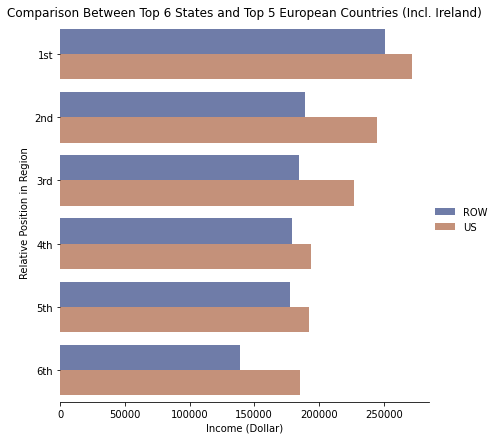

In [29]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=concated, kind="bar",
    x="total comp", y="position", hue="region",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Relative Position in Region")
plt.xlabel('Income (Dollar)')
plt.title('Comparison Between Top 6 States and Top 5 European Countries (Incl. Ireland)')
g.legend.set_title("")
plt.savefig("../Graph Outputs/us-vs-countries.png", bbox_inches='tight')

### U.S Vs R.O.W Analysis
In the final graph, we are missing some information regarding the countries and states being directly compared. However, the important information that we can see is this:
* According to our data, employees in STEM related positions receive more compensation annually in the United States than they do in the rest of the World.
* The margins between earnings seem quite considerable.
---

## Conclusion
In this notebook, we investigated the earnings from STEM related positions in both the United States, and the Rest of the World. We understood that the coastal regions of the US offer greater opportunity in terms of STEM positions, whilst the midlands offer opportunity in other sectors such as agriculture.

With this dataset being predominantely American, our data for the rest of the world was biased towards countries with less entries. We filtered out any countries with less than 5 recorded instances. We found that of the countries with the highest earning STEM eployees, very few are in the European Union. This emphasises the globalisation of the STEM-related market.

Finally, we wanted to compare the eanrings of the top states in America, with the earnings of the top countries in the rest of the world, including Ireland. We found that in all cases of our comparison, American states earn more than the averages of European countries. On this simple analysis alone, it would be worth while to consider a position in the United States if you would like to earn more in your position. However, this is not an exhaustive analysis, and ofcourse other factors are in play.